## Sentiment140 dataset with 1.6 million tweets

Dans ce notebook, nous allons mettre en oeuvre une analyse générale de notre base de données en s'appuyant sur les axes suivants :

* [I- Importer les bibliothèques importantes](#chapter1)
* [II- Importer les données](#chapter2)
* [III- Caractéristiques des données ](#chapter3)
    * [1- Apercu des données](#section_3_1)
        * [1-1 Rennomer les colonnes](#section_3_1_1)
    * [2- Le nombre de lignes et colonnes](#section_3_2)
    * [3- Les valeurs manquantes](#section_3_3)
    * [4- Les doublons](#section_3_4)
    * [5- Le type des variables](#section_3_5)
* [IV- Analyse de données](#chapter4)
    * [1- La distribution des sentiments](#section_4_1)
    * [2- La taille des commentaires](#section_4_2)

Après avoir pris une idée générale sur les données ainsi que les variables, nous allons attaquer une approche qui se base sur le ***Deep Learning*** et plus précisément **`Bi_LSTM`** model en se basant sur les axes suivantes :

* [V- Nettoyage de données](#chapter5)
* [VI- Diviser les données](#chapter6)
* [VII- Word2Vec](#chapter7)
    * [1- Implementer FastText](#section_7_1)
    * [2- Tokenisation](#section_7_2)
    * [3- Padding](#section_7_3)
    * [4- Construire Embedding_Matrix](#section_7_4)
* [VIII- Modèles](#chapter8)
* [IX- Evaluation](#chapter9)

Le lien correspond au téléchargement des données : [Sentiment140 dataset with 1.6 million tweets](https://www.kaggle.com/kazanova/sentiment140) 


## I- Importer les bibliothèques importantes <a class="anchor" id="chapter1"></a>

In [ ]:
'''Décommentez ceci pour installer ces bibliothèques 

!pip install gensim

'''

In [25]:
import numpy as np
import pandas as pd
import time


import matplotlib.pyplot as plt
import seaborn as sns

import re
import string

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import gensim
from gensim.models import KeyedVectors

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.layers import SpatialDropout1D, Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from keras.layers.embeddings import Embedding
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

from numpy import loadtxt
from keras.models import load_model

import warnings
warnings.filterwarnings("ignore")

## II- Importer les données <a class="anchor" id="chapter2"></a>

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [4]:
path = '/content/gdrive/MyDrive/Colab Notebooks/data_tweet.csv'

In [5]:
data = pd.read_csv(path, header = None, encoding='latin-1')

## III- Caractéristiques des données <a class="anchor" id="chapter3"></a>

Dans cette section, nous allons analyser les différentes caractéristiques des données tel que :

- Apercu des données
- Le nombre de lignes et colonnes
- Les valeurs manquantes
- Les doublons
- Le type des variables

### 1- Apercu des données <a class="anchor" id="section_3_1"></a>

In [6]:
data.head(3)

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...


#### 1-1 Rennomer les colonnes <a class="anchor" id="section_3_1_1"></a>

In [7]:
data.columns = ["TARGET", "ids", "date", "flag", "user", "Review"]
data.head(3)

,TARGET,ids,date,flag,user,Review
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...


### 2- Le nombre de lignes et colonnes <a class="anchor" id="section_3_2"></a>

In [8]:
print("Data contient {} lignes et {} colonnes.".format(data.shape[0], data.shape[1]))

Data contient 1600000 lignes et 6 colonnes.


|***Colonne :***  |  <span style="color:red">TARGET</span> | ids | date | flage | user | <span style="color:blue">Review</span> |  
|---|---|---|---|---|---|---|
| |   |   |   | | | |  

### 3- Les valeurs manquantes <a class="anchor" id="section_3_3"></a>

In [8]:
data.isnull().sum()

TARGET    0
ids       0
date      0
flag      0
user      0
Review    0
dtype: int64

### 4- Les doublons <a class="anchor" id="section_3_4"></a>

In [9]:
print("Nous avons  {} doublons dans Data.".format(data.duplicated().sum()))

Nous avons  0 doublons dans Data.


***Remarque :***
- Nous allons laisser que les colonnes qui nous interessent à savoir : 
    - **TARGET** 
    - **Review**

In [9]:
data.drop(['ids','date','flag','user'], axis = 1, inplace = True)

In [10]:
data.head(3)

,TARGET,Review
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...


***NB :***
- Dans le but de simplifier l'analyse de nos données, nous allons ajouter une nouvelle colonne " *Sentiment* " qui contient :
    - **0** si **TARGET = 0**
    - **1** si **TARGET = 4**

In [11]:
lab_to_sentiment = {0:0, 4:1}

def label_decoder(label):
    return lab_to_sentiment[label]

data["sentiment"] = data.TARGET.apply(lambda x: label_decoder(x))

In [12]:
data.head(3)

,TARGET,Review,sentiment
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,0,is upset that he can't update his Facebook by ...,0
2,0,@Kenichan I dived many times for the ball. Man...,0


In [14]:
print(data.TARGET.value_counts(),'\n\n',data.sentiment.value_counts())

4    800000
0    800000
Name: TARGET, dtype: int64 

 1    800000
0    800000
Name: sentiment, dtype: int64


## IV- Analyse de données <a class="anchor" id="chapter4"></a>

- Nous allons définir deux fonctions de visualisation pour simplifier la tâche dans les étapes suivantes.

In [15]:
def pie(data,col):
    labels = data[col].value_counts().keys().tolist()
    n = len(labels)
    if n==2:
        colors = ['#66b3ff', '#fb3999']
    elif n==3:
        colors = ['#66b3ff', '#fb3999', '#ffcc99']
    elif n==4:
        colors = ['#66b3ff', '#fb3999', '#ffcc99',"#66f3ff"]
    elif n==5:
        colors = ['#66b3ff', '#fb3999', '#ffcc99',"#66f3ff",'#adcc99']
    elif n==6:
        colors = ['#66b3ff', '#fb3999', '#ffcc99',"#66f3ff",'#adcc99',"#db7f23"]
    
    fig1, f1 = plt.subplots()
    f1.pie(data[col].value_counts(), labels=labels, colors = colors, autopct='%1.1f%%',shadow=False, startangle=60) 
    f1.axis('equal')
    plt.tight_layout()
    plt.show()
    
def histo(data,col):
    plt.figure(figsize = (10, 8))
    sns.histplot(data=data, x=col, hue = data[col], fill=True)

### 1- La distribution des sentiments <a class="anchor" id="section_4_1"></a>

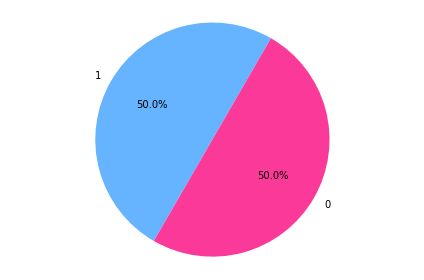

In [16]:
pie(data,"sentiment")

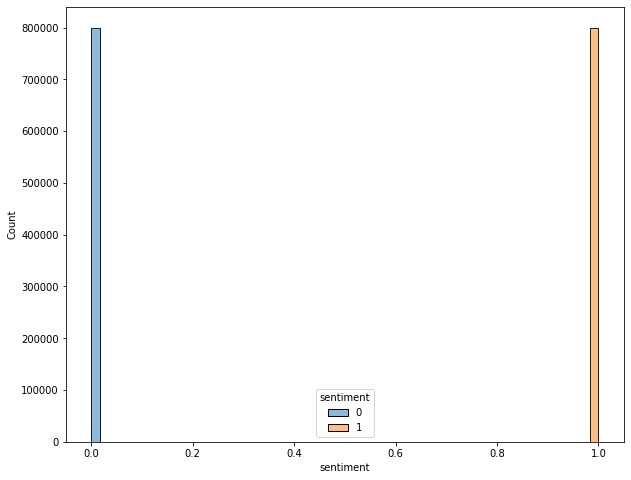

In [17]:
histo(data,"sentiment")

***Commentaire :***

- D'après les résultats obtenus, on peut conclure qu'on a ***une base de données équilibrée***.

### 2- La taille des commentaires <a class="anchor" id="section_4_2"></a>

Dans le but d'avoir une idée générale sur le comportement des utilisateurs, la taille des commentaires peut nous donner un aperçu sur l'utilisation de la langue.

Or, même pour l'étape de la vectorisation des données, cette partie va nous donner une idée sur la taille des vecteurs et même du vocabulaire.

In [18]:
def compte_mots(phrase):
    return len(phrase.split())

In [19]:
positive_data = data[data["sentiment"] == 0]

negative_data = data[data["sentiment"] == 1]

In [20]:
positive_data["Number_of_words"] = positive_data.Review.apply(lambda x: compte_mots(x))
negative_data["Number_of_words"] = negative_data.Review.apply(lambda x: compte_mots(x))

In [21]:
print("Le maximum de mots utilisé dans les reviews positives est :", max(positive_data.Number_of_words))
print("Le maximum de mots utilisé dans les reviews négatives est :", max(negative_data.Number_of_words))

Le maximum de mots utilisé dans les reviews positives est : 57
Le maximum de mots utilisé dans les reviews négatives est : 64


***Remarque :***

- Dans le but d'avoir une idée générale sur le comportement des gens qui laissent des commentaires positifs contre ceux qu'ils laissent des commentaires négatifs, nous allons visualiser le graphe suivant : 

(0.0, 200.0)

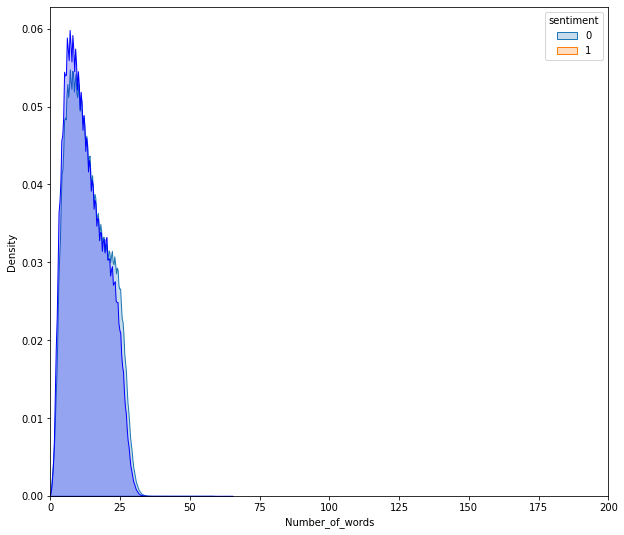

In [22]:
plt.figure(figsize=(10,9))

p1=sns.kdeplot(positive_data['Number_of_words'], hue = data['sentiment'],  shade=True, color="r")
p1=sns.kdeplot(negative_data['Number_of_words'], shade=True, color="b")

plt.xlim(0, 200)

***Commentaire :***

- On remarque qu'il y a le même comportement entre les utilisateurs.

## V- Nettoyage de données <a class="anchor" id="chapter5"></a>

Les textes de tweet se composent souvent de mentions d'autres utilisateurs, de textes de liens hypertextes, d'émoticônes et de ponctuations. 

Afin de les utiliser pour notre modèle. Nous ne pouvons pas autoriser ces textes pour la formation d'un modèle. 

Nous devons donc nettoyer les données textuelles en utilisant diverses méthodes de prétraitement et de nettoyage.

Pour bien rendre la manipulation des mots plus facile, nous allons définir un dictionnaire pour traiter la négation.

In [13]:
dict_neg = {"aren't" : "are not","can't" : "cannot","couldn't" : "could not","didn't" : "did not","doesn't" : "does not",
"don't" : "do not","hadn't" : "had not","hasn't" : "has not","haven't" : "have not","he'd" : "he would","he'll" : "he will",
"he's" : "he is","i'd" : "I would","i'd" : "I had","i'll" : "I will","i'm" : "I am","isn't" : "is not","it's" : "it is",
"it'll":"it will","i've" : "I have","let's" : "let us","mightn't" : "might not","mustn't" : "must not","shan't" : "shall not",
"she'd" : "she would","she'll" : "she will","she's" : "she is","shouldn't" : "should not","that's" : "that is",
"there's" : "there is","they'd" : "they would","they'll" : "they will","they're" : "they are","they've" : "they have",
"we'd" : "we would","we're" : "we are","weren't" : "were not","we've" : "we have","what'll" : "what will","what're" : "what are",
"what's" : "what is","what've" : "what have","where's" : "where is","who'd" : "who would","who'll" : "who will",
"who're" : "who are","who's" : "who is","who've" : "who have","won't" : "will not","wouldn't" : "would not","you'd" : "you would",
"you'll" : "you will","you're" : "you are","you've" : "you have","'re": " are","wasn't": "was not","we'll":" will",
"didn't": "did not"}

In [14]:
def preprocessing(x):
    x = x.lower()
    
    x = re.sub(r"http\S+|www\S+|https\S+","", x, flags=re.MULTILINE)
    x = x.replace("<br />", "")
    
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030""]+", flags=re.UNICODE)
    emoji_pattern.sub(r'', x)
    
    words = x.split()
    reformed = [dict_neg[i] if i in dict_neg else i for i in words]
    x = " ".join(reformed)
    
    x = re.sub(r'[^a-zA-z.,!?/:;\"\'\s]', '', x)
    
    x = x.translate(str.maketrans("","", string.punctuation))
    
    x = x.strip()
    return x

In [15]:
%%time
data["Clean_reviews"] = data.Review.apply(lambda x: preprocessing(x))

Wall time: 18.6 s


In [16]:
print('- Avant le prétraitement \n\n',data["Review"][0])
print("\n-----------------------------------------------\n")
print('- Après le prétraitement \n\n',data["Clean_reviews"][0])

- Avant le prétraitement 

 @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D

-----------------------------------------------

- Après le prétraitement 

 switchfoot  a that is a bummer you shoulda got david carr of third day to do it d


***Remarque :***
- Nous remarquons que les données sont bien prétraités et ils sont prêts pour les utiliser.

## VI- Diviser les données <a class="anchor" id="chapter6"></a>

- Le but de cette étape est de diviser les données en deux parties :
    - La partie d'entrainement *(Train_Set)* : **80%**
    - La partie du test *(Test_Set)* : **20%**

$$
1.600.000 * 80\% = 1.280.000
$$
$$
1.600.000 * 20\% = 320.000
$$

***NB :***
- Nous allons extraire une partie de *Validation* du *Train_Set*.

In [17]:
X = data.Clean_reviews
y = data.sentiment

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.20, 
                                                    random_state = 42)

In [19]:
print('Train set', X_train.shape)
print('Test set', X_test.shape)

Train set (1280000,)
Test set (320000,)


## VII- Word2Vec <a class="anchor" id="chapter7"></a>

**Word Embeddings** sont essentiellement un moyen de convertir les mots en vecteurs de représentation. L'objectif est de pouvoir générer des vecteurs de représentation similaires ou proches pour des mots ayant une signification similaire.

Alors pour satisfaire cela, nous allons adopter dans notre approche ***FastText***.

Le lien correspond au téléchargement du Word Embeddings prétraité : [Aligned Vectors](https://fasttext.cc/docs/en/aligned-vectors.html) 


### 1- Implementer FastText <a class="anchor" id="section_7_1"></a>

In [ ]:
'''Décommentez ceci pour charger Word Embeddings pour la 1er fois

%%time
source_word_vec = KeyedVectors.load_word2vec_format("wiki.en.align.vec.txt", 
                                                    binary = False)
source_word_vec.save('source_word_vec')

'''

In [2]:
%%time
path_w2v = '/content/gdrive/MyDrive/Colab Notebooks/source_word_vec'
source_word_vec = KeyedVectors.load(path_w2v)

Wall time: 4.21 s


### 2- Tokenisation  <a class="anchor" id="section_7_2"></a>

A partir d'une séquence de caractères et d'une unité documentaire définie, la tokénisation consiste à la découper en morceaux, appelés tokens, en éliminant éventuellement certains caractères, comme la ponctuation. Ce processus est appelé ***tokenisation***.

In [20]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

Wall time: 19.1 s


In [21]:
word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1

### 3- Padding  <a class="anchor" id="section_7_3"></a>

D'après l'analyse qui était faite au dessus, nous avons vu que le maximum de mots utilisé est environ de ***64***.

Donc nous allons prendre `maxlen = 65`.

In [22]:
%%time
MAX_SEQUENCE_LENGTH = 65

X_train = pad_sequences(tokenizer.texts_to_sequences(X_train),
                        maxlen = MAX_SEQUENCE_LENGTH)
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:", X_train.shape)
print("Testing X Shape:", X_test.shape)

Training X Shape: (1280000, 65)
Testing X Shape: (320000, 65)
Wall time: 24.1 s


### 4- Construire Embedding_Matrix  <a class="anchor" id="section_7_4"></a>

In [23]:
%%time
embedding_matrix = np.zeros((vocab_size, 300))

for word, i in word_index.items():
    if word in source_word_vec :
        embedding_vector = source_word_vec[word]
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

Wall time: 1.05 s


In [24]:
embedding_matrix.shape[0] == vocab_size

True

## VIII- Modèles <a class="anchor" id="chapter8"></a>

Nous sommes prêts maintenant à construire notre modèle de Deep Learning. Lors du développement d'un modèle Deep Learning, nous devons garder à l'esprit des éléments clés à savoir : 
- L'architecture du modèle
- Le réglage de l'hyperparamètre
- Les performances du modèle

Pour l'architecture du modèle, nous utilisons : 

- **Embedding Layer** : Génère Embedding Vector pour chaque séquence d'entrée.

- **Conv1D Layer** : Elle est utilisée pour convoluer les données en vecteurs de caractéristiques plus petits.

- **Bi-LSTM (Bidirectional Long Short Term Memory)** : il s'agit d'une variante du RNN qui dispose d'une cellule d'état de mémoire pour apprendre le contexte des mots qui se trouvent plus loin dans le texte et qui ont une signification contextuelle plutôt que les mots voisins comme dans le cas du RNN.

- **Dense Layer** : Entièrement connectées pour la classification

**NB :**
- **SpatialDropout1D Layer** : Si les cadres adjacentes dans les features sont fortement corrélées (comme c'est normalement le cas dans les premières couches de convolution), le dropout régulier ne régularisera pas les activations et ne fera que diminuer le taux d'apprentissage effectif. Dans ce cas, *SpatialDropout1D* aidera à promouvoir l'indépendance entre les features et devrait être utilisé à la place.

In [38]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 
                            300, 
                            weights = [embedding_matrix], 
                            input_length = MAX_SEQUENCE_LENGTH, 
                            trainable=False)
model.add(embedding_layer)
model.add(SpatialDropout1D(0.2))
model.add(Conv1D(65, 5, activation='relu'))
model.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer = Adam(learning_rate=0.001), 
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 65, 300)           188725200 
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 65, 300)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 61, 65)            97565     
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66560     
_________________________________________________________________
dense (Dense)                (None, 512)               66048     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               2

In [39]:
history = model.fit(X_train, y_train, batch_size=1024, epochs=10,
                    validation_data=(X_test, y_test), callbacks=[ReduceLROnPlateau])

Epoch 1/10
1250/1250 [==============================] - 543s 410ms/step - loss: 0.4861 - accuracy: 0.7633 - val_loss: 0.4284 - val_accuracy: 0.8009
Epoch 2/10
1250/1250 [==============================] - 512s 410ms/step - loss: 0.4428 - accuracy: 0.7928 - val_loss: 0.4190 - val_accuracy: 0.8073
Epoch 3/10
1250/1250 [==============================] - 514s 412ms/step - loss: 0.4296 - accuracy: 0.8007 - val_loss: 0.4094 - val_accuracy: 0.8113
Epoch 4/10
1250/1250 [==============================] - 514s 411ms/step - loss: 0.4213 - accuracy: 0.8053 - val_loss: 0.4043 - val_accuracy: 0.8152
Epoch 5/10
1250/1250 [==============================] - 514s 411ms/step - loss: 0.4152 - accuracy: 0.8093 - val_loss: 0.4050 - val_accuracy: 0.8157
Epoch 6/10
1250/1250 [==============================] - 513s 410ms/step - loss: 0.4103 - accuracy: 0.8116 - val_loss: 0.3976 - val_accuracy: 0.8189
Epoch 7/10
1250/1250 [==============================] - 512s 410ms/step - loss: 0.4066 - accuracy: 0.8136 - val_

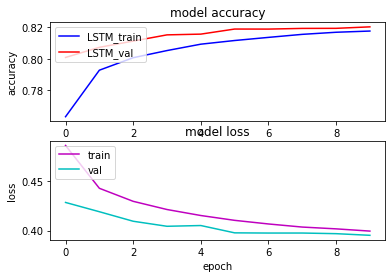

In [40]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

## IX- Evaluation <a class="anchor" id="chapter9"></a>

In [36]:
score = model.evaluate(X_test, y_test, verbose=1)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

10000/10000 [==============================] - 573s 55ms/step - loss: 0.3951 - accuracy: 0.8203
accuracy: 82.03%


In [59]:
model.save("/content/gdrive/MyDrive/Colab Notebooks/model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
'''Décommentez ceci pour charger le modèle 

path_model = '/content/gdrive/MyDrive/Colab Notebooks/model.h5'
model = load_model(path_model)

'''

In [37]:
def decode_sentiment(score):
    return 1 if score>0.5 else 0

In [38]:
scores = model.predict(X_test, verbose=1)

y_pred_1d = [decode_sentiment(score) for score in scores]

10000/10000 [==============================] - 493s 49ms/step


In [45]:
print(classification_report(y_test, y_pred_1d))

              precision    recall  f1-score   support

           0       0.80      0.86      0.83    159494
           1       0.85      0.79      0.81    160506

    accuracy                           0.82    320000
   macro avg       0.82      0.82      0.82    320000
weighted avg       0.82      0.82      0.82    320000

